In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

sns.set_style('whitegrid') 
sns.set_palette('pastel')  

import warnings
warnings.simplefilter("ignore")

In [3]:
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('fraudTest.csv', index_col='Unnamed: 0')

# Step1. Exploratory Data Analysis

In [4]:
train_df.head(3)
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

(1296675, 22)

In [5]:
is_fraud=train_df['is_fraud'].value_counts()
print("Yes: ",is_fraud[1])
print("No: ", is_fraud[0])

Yes:  7506
No:  1289169


In [6]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


No null and duplicated values in the training dataset

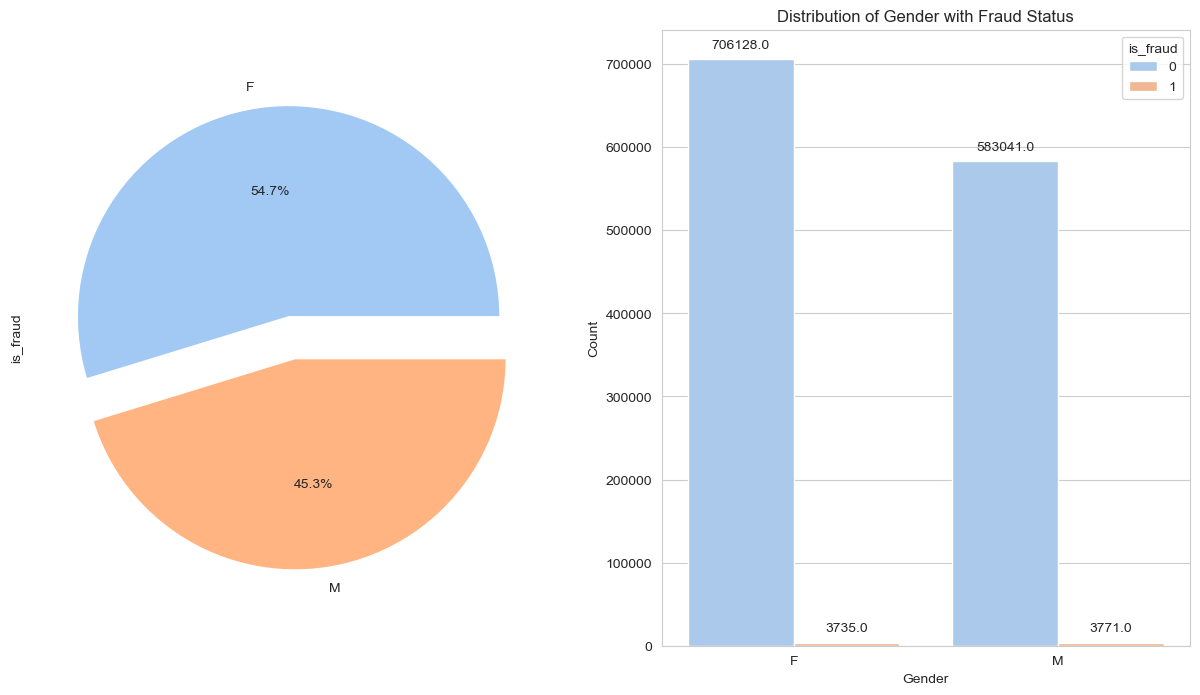

In [7]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

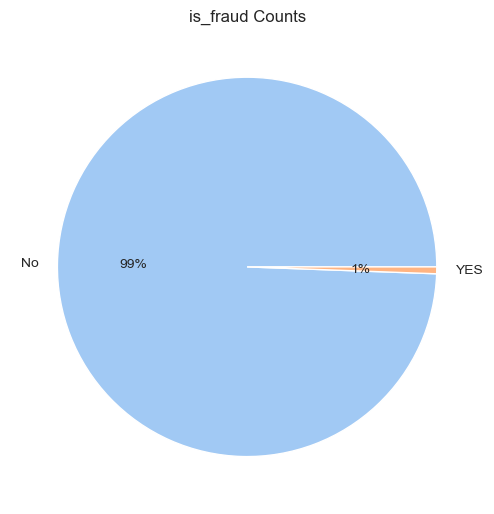

In [8]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [9]:
# Changing 'trans_date_trans_time' to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [10]:
# creating 'hour' and 'month'
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ... city_pop  \
0                561 Perry Cove  Moravian Falls  ...     3495   
1  43039 Riley Greens Suite 393          Orient  ...      149   
2      594 White Dale Suite 530      Malad City  ...     4154   
3   9443 Cynthia Court Apt. 038         Boulder  ...     1939   
4              408 Bradley Rest        Doe Hill  ...       99   

                                 job         dob  \
0          Psychologist, counselling  1988-03-09   
1  Special educational needs teacher  1978-06-21   
2        Nature conservation officer  1962-01-19   
3                    Patent attorney  1967-01-12   
4     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

  is_fraud  hour  month  
0        0     0      1  
1        0     0      1  
2        0     0      1  
3        0     0      1  
4        0     0      1  

[5 rows x 24 columns]

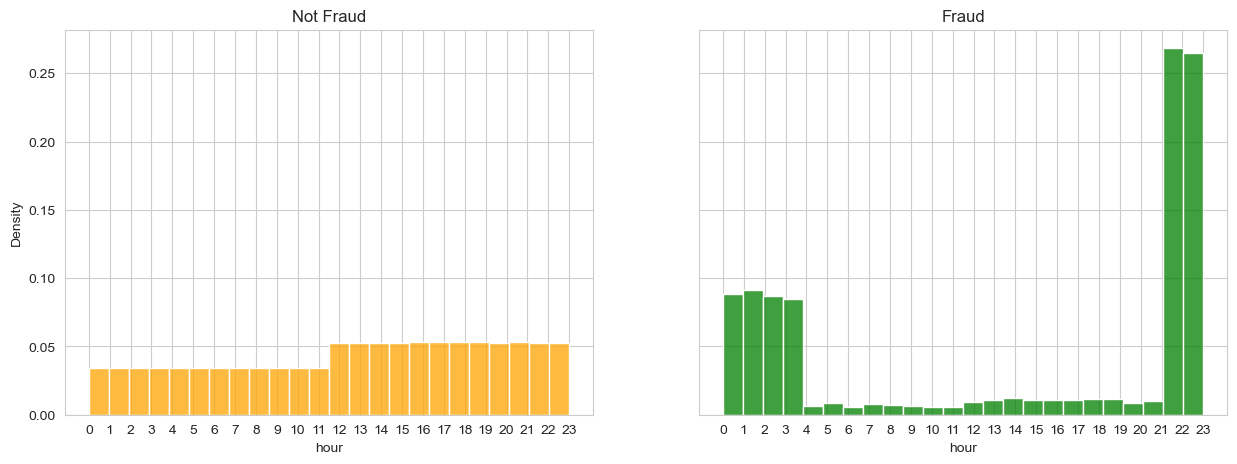

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

'hour' could be an important factor in predicting fradulent transactions

# Step 2. Pre-processing

In [12]:
# remove non-useful columns for both test and train datasets
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

merchant     category     amt   last gender  \
0       fraud_Rippin, Kub and Mann     misc_net    4.97  Banks      F   
1  fraud_Heller, Gutmann and Zieme  grocery_pos  107.23   Gill      F   

       lat      long  city_pop                                job  merch_lat  \
0  36.0788  -81.1781      3495          Psychologist, counselling  36.011293   
1  48.8878 -118.2105       149  Special educational needs teacher  49.159047   

   merch_long  is_fraud  hour  month  
0  -82.048315         0     0      1  
1 -118.186462         0     0      1

In [13]:
# remove unnecessary string in both test and train datasets
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))
test_df['merchant'] = test_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [14]:
X_train=train_df.drop("is_fraud",axis=1)
y_train=train_df['is_fraud']

X_test=test_df.drop("is_fraud",axis=1)
y_test=test_df['is_fraud']

### Constructing a pipeline of WOEEncoder, StandardScaler, SMOTE (Oversampling)

In [15]:
X_train.isna().sum()

merchant      0
category      0
amt           0
last          0
gender        0
lat           0
long          0
city_pop      0
job           0
merch_lat     0
merch_long    0
hour          0
month         0
dtype: int64

In [16]:
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import make_pipeline
from category_encoders import BinaryEncoder

In [17]:
# # mapping gender to 1, 0
# # Binary , Onehot Encoding -> preprocessor
# def map_gender(X):
#     if X['gender'].dtype in ['int64', 'float64']:
#         return X  
#     else: 
#         X['gender'] = X['gender'].map({'F': 0, 'M': 1})
#         return X

In [18]:
# preprocessing
preprocessor=ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(),['amt','lat','long','city_pop','merch_lat','merch_long','hour','month']), # for numerical var
        ('categorical', WOEEncoder(),['merchant', 'category', 'last','job']), # for categorical var
        ('binary', BinaryEncoder(), ['gender'])  # for binary encoding
    ], 
    remainder='passthrough'
    
)

In [19]:
preprocessing_pipeline = make_pipeline( 
    preprocessor
)

### New pipeline for the model 

In [20]:
DTmodel_pipeline=make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    DecisionTreeClassifier()
)

In [20]:
# Using grid Search to fit the best model
param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10]
}


grid_search = GridSearchCV(estimator=DTmodel_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train,y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


In [21]:
best_DT_model=DecisionTreeClassifier(max_depth=10,min_samples_split=5,random_state=42)

In [22]:
best_pipeline=make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    best_DT_model
)

In [23]:
best_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', StandardScaler(),
                                                  ['amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'hour',
                                                   'month']),
                                                 ('categorical', WOEEncoder(),
                                                  ['merchant', 'category',
                                                   'last', 'job']),
                                                 ('binary', BinaryEncoder(),
                                                  ['gender'])])),
                ('smote', SMOTE(random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                        random_state=42))])

In [24]:
y_pred = best_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
DT_final_accuracy = accuracy_score(y_pred,y_test)
print('Decision Tree accuracy is: {:.2f}%'.format(DT_final_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.09      0.57      0.16      2145

    accuracy                           0.98    555719
   macro avg       0.55      0.77      0.57    555719
weighted avg       0.99      0.98      0.99    555719

Decision Tree accuracy is: 97.68%


In [25]:
import joblib

In [26]:
joblib.dump(best_pipeline, 'best_pipeline.joblib')

['best_pipeline.joblib']

# FastAPI

In [27]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import Union
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from category_encoders import WOEEncoder
from datetime import datetime
import asyncio
import uvicorn

In [28]:
best_pipeline=joblib.load("best_pipeline.joblib")

In [29]:
from fastapi.testclient import TestClient

In [30]:
api_title ="CreditCardFraudDetectionApp"
api_description="""
CreditCardFraudDetectionApp allows you to predict if a transaction is fraudulent or not.
"""
app=FastAPI(title=api_title,description=api_description)

class TransactionInput(BaseModel):
    merchant: str
    category: str
    amt: float
    last: str
    gender: str  
    lat: float
    long: float
    city_pop: int
    job: str
    merch_lat: float
    merch_long: float 
    hour: int
    month: int

class PredictOutput(BaseModel):
    is_fraud: bool
    probability: float   
best_pipeline=joblib.load("best_pipeline.joblib")

@app.get("/")
def root():
    return "Hello! This is the credit card fraud prediction ML service!"

@app.post("/predict", response_model=PredictOutput)
def predict_fraud(transaction: TransactionInput):
    data = {
        'merchant': [transaction.merchant],
        'category': [transaction.category],
        'amt': [transaction.amt],
        'last': [transaction.last],
        'gender': [transaction.gender],
        'lat': [transaction.lat],
        'long': [transaction.long],
        'city_pop': [transaction.city_pop],
        'job': [transaction.job],
        'merch_lat': [transaction.merch_lat],
        'merch_long': [transaction.merch_long],
        'hour': [transaction.hour],
        'month': [transaction.month]
    }
    input_data = pd.DataFrame(data)
    
    # input_data_processed=preprocessing_pipeline.transform(input_data)

    # predict
    prediction=best_pipeline.predict(input_data)
    probability=best_pipeline.predict_proba(input_data)[:,1]

    return PredictOutput(is_fraud=bool(prediction),probability=float(probability))


In [31]:
import nest_asyncio
nest_asyncio.apply()

In [32]:
async def run_server():
    await uvicorn.run(app, host="127.0.0.1", port=8000)

await run_server()

INFO:     Started server process [23732]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:64297 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:64297 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:64297 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:64298 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [23732]


TypeError: object NoneType can't be used in 'await' expression